# Torneo SNA 2025

* Nombre equipo:
  * 3DIC
* Participantes:
  * Paula Corral rebollar
  * Lucía Cuevas Serrano

# Instalar dependencias

Instalamos las dependencias y cargamos las librerías.

In [ ]:
!pip install torch_geometric

#!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)")+.html
import warnings
warnings.filterwarnings("ignore", message="The usage of `scatter")

In [ ]:
import networkx as nx
import os
import os.path as osp
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.utils.convert import from_networkx
from zipfile import ZipFile
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from torch.nn import Module
from torch_geometric.nn import GINConv, global_mean_pool, global_max_pool, BatchNorm
from sklearn.metrics import mean_squared_error
import itertools
import time
import re
import copy

# Cargar el dataset

Cargamos la parte del dataset correspondiente al train. El test se cargará al final.

In [ ]:
class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/WTBtQ3HH2GjpGAi/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        self.train_idx = torch.load(self.processed_paths[1], weights_only=False)
        self.test_idx = torch.load(self.processed_paths[2], weights_only=False)

    @property
    def raw_file_names(self):
        return ['nx_graphs.zip']

    @property
    def processed_file_names(self):
        return ['geometric_data_processed.pt', "train_idx.pt", "test_idx.pt"]

    @property
    def num_classes(self):
        return 1

    @property
    def num_features(self):
        return 9

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='nx_graphs.zip')

    def process(self):

        with ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

        data_list = []
        train_idx = []
        test_idx = []
        for f in os.listdir(osp.join(self.raw_dir, "nx_graphs")):
            G = nx.read_gml(osp.join(self.raw_dir, "nx_graphs", f))
            data = from_networkx(G)
            data.x = data.x.float()

            data.nid = torch.tensor([G.graph["molecule_id"]], dtype=torch.long)
            data_list.append(data)

            if G.graph["set"] == "training":
                data.y = torch.tensor([G.graph["y"]], dtype=torch.float)
                train_idx.append(G.graph["molecule_id"])
            else:
                data.y = torch.tensor([torch.nan], dtype=torch.float)
                test_idx.append(G.graph["molecule_id"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data_list.sort(key=lambda x: x.nid.item())

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(train_idx, self.processed_paths[1])
        torch.save(test_idx, self.processed_paths[2])

Number of molecules: 4200
Number of node attributes: 9
Example Graph: Data(x=[22, 9], edge_index=[2, 50], y=[1], molecule_id=[1], set='training', nid=[1])
Training set size: 3360
Test set size: 840
Trainning distribution: count    3360.000000
mean        2.200554
std         1.199276
min        -1.500000
25%         1.437500
50%         2.360000
75%         3.100000
max         4.500000
dtype: float64
Test distribution: Counter({'nan': 840})


Text(0.5, 1.0, 'Histogram of training labels')

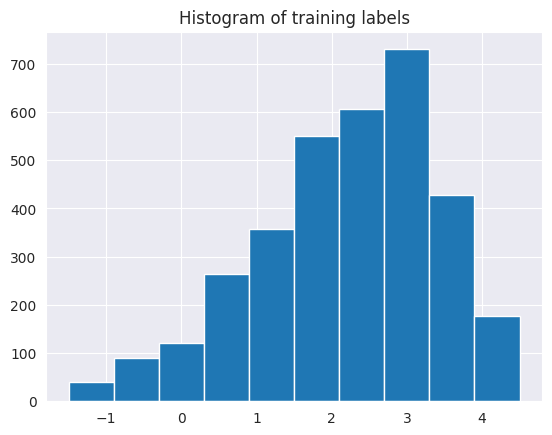

In [ ]:
sns.set_style("darkgrid")

dataset = TournamentDataset(root='tournament')

print(f"Number of molecules: {len(dataset)}")
print(f"Number of node attributes: {dataset.num_features}")
print(f"Example Graph: {dataset[0]}")
print(f"Training set size: {len(dataset.train_idx)}")
print(f"Test set size: {len(dataset.test_idx)}")
print(f"Trainning distribution: {pd.Series([dataset[i].y.item() for i in dataset.train_idx]).describe()}")
print(f"Test distribution: {Counter([str(dataset[i].y.item()) for i in dataset.test_idx])}")

pd.Series([dataset[i].y.item() for i in dataset.train_idx]).hist()
plt.title("Histogram of training labels")

# Dividir datos

Aplicamos sampling con estratificación para preparar los datos.

## Train y validation loaders

Estos loaders se utilizaran durante toda la práctica para todas las pruebas.

El split previo de este cuaderno era así:

![Split previo](split_previo.png)

In [ ]:
# Índices y targets
train_indices = np.array(dataset.train_idx)
y_values = np.array([dataset[i].y.item() for i in train_indices])

# Binning para estratificación
n_bins = 10
bins, bin_edges = pd.qcut(y_values, q=n_bins, duplicates="drop", retbins=True)
bins = bins.codes

# Split estratificado
train_idx, val_idx = train_test_split(
    train_indices, test_size=0.15, stratify=bins, random_state=42
)

# Calcular pesos inversos por bin
train_targets = np.array([dataset[i].y.item() for i in train_idx])
train_bins = pd.cut(train_targets, bins=bin_edges, include_lowest=True)

bin_counts = train_bins.value_counts().sort_index()
bin_weights = 1.0 / bin_counts
bin_weights /= bin_weights.mean()  

# Crear array de pesos por sample
sample_weights = np.array([bin_weights.iloc[code] for code in train_bins.codes])
sample_weights = torch.tensor(sample_weights, dtype=torch.float)

# WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=128, sampler=sampler)
val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=len(val_idx), shuffle=False)

print("Train size:", len(train_idx))
print("Validation size:", len(val_idx))


Train size: 2856
Validation size: 504


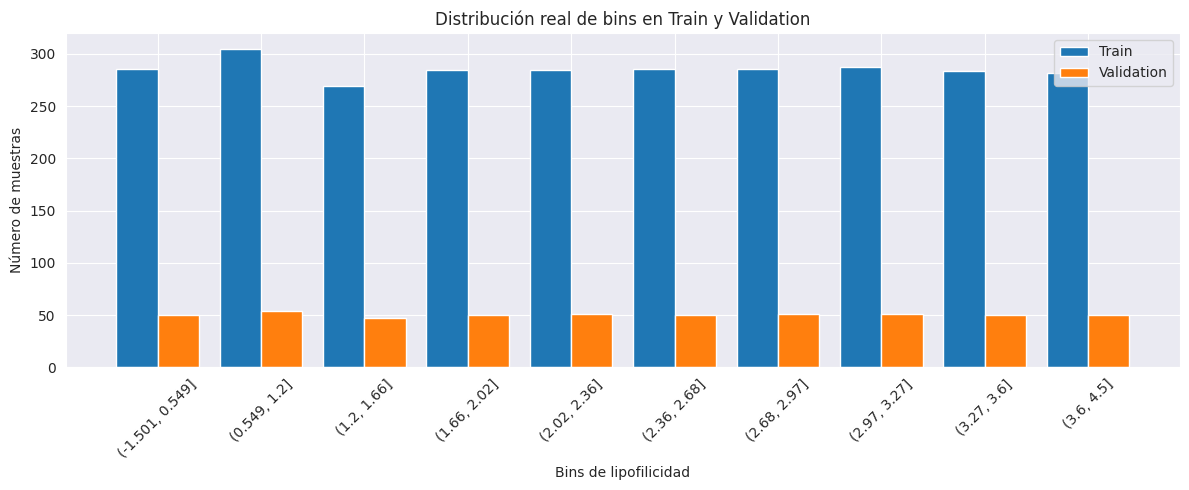

In [ ]:
# Labels del training original
all_y = np.array([dataset[i].y.item() for i in dataset.train_idx])

# Bin edges
bin_edges = pd.qcut(
    all_y, q=n_bins, duplicates="drop", retbins=True
)[1]

# Train
train_y = np.array([dataset[i].y.item() for i in train_idx])
train_bins = pd.cut(train_y, bins=bin_edges, include_lowest=True)
train_counts = train_bins.value_counts().sort_index()

# Validation
val_y = np.array([dataset[i].y.item() for i in val_idx])
val_bins = pd.cut(val_y, bins=bin_edges, include_lowest=True)
val_counts = val_bins.value_counts().sort_index()

# Barplot
x = np.arange(len(train_counts))
width = 0.4

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_counts.values, width, label="Train")
plt.bar(x + width/2, val_counts.values, width, label="Validation")

plt.xticks(x, [str(interval) for interval in train_counts.index], rotation=45)
plt.xlabel("Bins de lipofilicidad")
plt.ylabel("Número de muestras")
plt.title("Distribución real de bins en Train y Validation")
plt.legend()
plt.tight_layout()
plt.show()


## Train loader final

Este loader solo se utilizará al final de la práctica para entrenar el modelo definitivo.

In [ ]:
# Índices completos de training
final_train_idx = np.array(dataset.train_idx)
final_y = np.array([dataset[i].y.item() for i in final_train_idx])

# Bins
n_bins = 10
final_bins, bin_edges = pd.qcut(
    final_y, q=n_bins, duplicates="drop", retbins=True
)
final_bins = final_bins.codes

# Pesos inversos por bin
bin_counts = pd.Series(final_bins).value_counts().sort_index()
bin_weights = 1.0 / bin_counts
bin_weights /= bin_weights.mean()

# Pesos por sample
sample_weights = torch.tensor(
    [bin_weights.iloc[b] for b in final_bins],
    dtype=torch.float
)

# Sampler final
final_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoader final
train_loader_final = DataLoader(
    [dataset[i] for i in final_train_idx],
    batch_size=128,
    sampler=final_sampler
)

print("Final training size:", len(final_train_idx))


Final training size: 3360


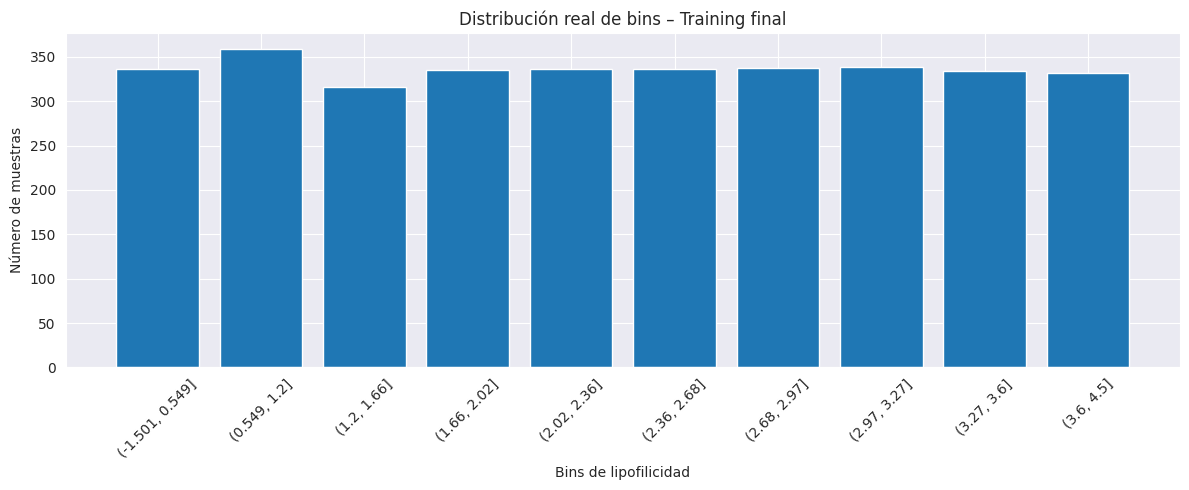

In [ ]:
final_counts = final_bins.value_counts().sort_index()

# Barplot
plt.figure(figsize=(12, 5))
plt.bar(
    range(len(final_counts)),
    final_counts.values
)

plt.xticks(
    range(len(final_counts)),
    [str(interval) for interval in final_counts.index],
    rotation=45
)

plt.xlabel("Bins de lipofilicidad")
plt.ylabel("Número de muestras")
plt.title("Distribución real de bins – Training final")
plt.tight_layout()
plt.show()


# Definir modelo

Definimos la estructura del modelo.

In [ ]:
class GINGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=256, n_layers=4, dropout=0.25, negative_slope=0.1):
        super().__init__()

        self.dropout = dropout
        self.negative_slope = negative_slope

        # Proyección inicial
        self.input_proj = torch.nn.Linear(num_features, hidden_channels)
        self.input_norm = torch.nn.BatchNorm1d(hidden_channels)

        # Capas GIN con residual
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        for _ in range(n_layers):
            mlp = torch.nn.Sequential(
                torch.nn.Linear(hidden_channels, hidden_channels),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_channels, hidden_channels)
            )
            self.convs.append(GINConv(mlp, train_eps=True))
            self.norms.append(BatchNorm(hidden_channels))

        # Pooling mean + max
        self.pool_dim = hidden_channels * 2

        # MLP
        self.pool_mlp = torch.nn.Sequential(
            torch.nn.Linear(self.pool_dim, hidden_channels),
            torch.nn.LeakyReLU(negative_slope),
            torch.nn.LayerNorm(hidden_channels),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.LeakyReLU(negative_slope),
            torch.nn.LayerNorm(hidden_channels),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.LeakyReLU(negative_slope),
            torch.nn.LayerNorm(hidden_channels // 2),
            torch.nn.Dropout(dropout)
        )

        self.regressor = torch.nn.Linear(hidden_channels // 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Proyección inicial
        x = self.input_proj(x)
        x = self.input_norm(x)

        # GIN profundo con residual
        for conv, norm in zip(self.convs, self.norms):
            h = conv(x, edge_index)
            h = norm(h)
            h = torch.nn.functional.leaky_relu(h, self.negative_slope)
            h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)
            x = torch.nn.functional.layer_norm(x + h, x.size()[1:])

        # Pooling
        x = torch.cat(
            [global_mean_pool(x, batch), global_max_pool(x, batch)],
            dim=1
        )

        # MLP de grafo
        x = self.pool_mlp(x)

        # Regresión
        out = self.regressor(x)
        out = torch.clamp(out, min=-3.0, max=7.0)
        return out


# Pruebas con modelos (entrenamiento)

Hacemos las pruebas necesarias para seleccionar la mejor combinación de hiperparámetros.


## Grid search

(Fase 1) Aplicamos grid search para buscar las mejores combinaciones de hiperparámetros.

In [ ]:
def loss_fn(y_pred, y_true):
    return torch.nn.functional.mse_loss(y_pred, y_true)

def run_epoch(model, loader, optimizer, device, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    y_true_all, y_pred_all = [], []

    for data in loader:
        data = data.to(device)

        if train:
            optimizer.zero_grad()

        y_true = data.y.view(-1)
        y_pred = model(data).view(-1)
        loss = loss_fn(y_pred, y_true)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        y_true_all.extend(y_true.detach().cpu().numpy())
        y_pred_all.extend(y_pred.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    return avg_loss, rmse


In [10]:
ejecutar=False

# Logs
import sys
log_file = "resultados_grid_search.txt"

if ejecutar:
    original_stdout = sys.stdout
    
    with open(log_file, "w") as f:
        sys.stdout = f  
    
        # Grid
        grid_hidden_channels=[64, 128, 256, 512]
        grid_n_layers= [2, 3, 4, 5, 6]
        grid_dropout= [0.1, 0.25, 0.4, 0.5]
        grid_negative_slope= [0.01, 0.05, 0.1, 0.2]
    
        grid = list(itertools.product(grid_hidden_channels, grid_n_layers, grid_dropout, grid_negative_slope))
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(device)
    
        for hidden_channels, n_layers, dropout, negative_slope in grid:
            start=time.time()
    
            # Modelo
            model = GINGraph(dataset.num_features, 1, hidden_channels=hidden_channels, n_layers=n_layers, dropout=dropout,negative_slope=negative_slope).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=1e-6)
            train_losses, train_rmses, val_losses, val_rmses = [], [], [], []
    
            # Criterio de parada
            num_epochs=1001
            patience = 100
            best_val_rmse = float('inf')
            epochs_no_improve = 0
    
            # Entrenar
            for epoch in range(num_epochs):
                train_loss, train_rmse = run_epoch(model, train_loader, optimizer, device, train=True)
                val_loss, val_rmse = run_epoch(model, val_loader, optimizer=None, device=device, train=False)
    
                scheduler.step()
    
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_model_state = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
    
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
    
            end=time.time()
            print(f"Modelo entrenado con hidden_channels={hidden_channels}, n_layers={n_layers}, dropout={dropout}, negative_slope={negative_slope}.")
            print(f"{round((end-start)/60, 2)} min, RMSE= {best_val_rmse}")
    
    sys.stdout = original_stdout


In [11]:
if ejecutar:
    with open("/kaggle/input/resultados-grid-search/resultados_grid_search.txt", "r") as f:
        lines = f.readlines()
    
    param_list = []
    
    for i, line in enumerate(lines):
        match = re.search(r"RMSE:\s*([0-9]*\.?[0-9]+)", line)
        if match:
            rmse_value = float(match.group(1))
            if rmse_value < 0.60:
                if i > 0:
                    param_line = lines[i-1]
    
                    # Extraer los valores de parámetros
                    params_match = re.findall(
                        r"hidden_channels=(\d+)|n_layers=(\d+)|dropout=([0-9.]+)|negative_slope=([0-9.]+)",
                        param_line
                    )
    
                    if params_match:
                        values = []
                        for t in params_match:
                            for v in t:
                                if v:
                                    v_clean = v.rstrip(".")
                                    if '.' in v_clean:
                                        values.append(float(v_clean))
                                    else:
                                        values.append(int(v_clean))
                        param_list.append(values)


In [12]:
if not ejecutar:
    param_list=[[64, 3, 0.1, 0.1], [64, 3, 0.1, 0.2], [64, 5, 0.1, 0.2], [64, 6, 0.1, 0.2], [128, 2, 0.1, 0.1], [128, 2, 0.1, 0.2], [128, 4, 0.1, 0.1], [128, 5, 0.1, 0.01], [128, 5, 0.1, 0.1], [256, 2, 0.1, 0.01], [256, 3, 0.1, 0.01], [256, 3, 0.1, 0.05], [256, 5, 0.1, 0.01], [256, 6, 0.1, 0.05], [512, 2, 0.1, 0.01], [512, 3, 0.1, 0.01], [512, 3, 0.1, 0.05], [512, 3, 0.1, 0.1]]

## Selección de la mejor combinación

(Fase 2) Entrenamos las mejores combinaciones 10 veces para obtener sus resultados.

In [ ]:
def run_training_session(train_loader, val_loader, device, num_epochs=1000, patience=50, combination=[256, 4, 0.25, 0.1], print_bool=False):

    model = GINGraph(dataset.num_features, 1, combination[0], combination[1], combination[2], combination[3]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_rmse = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    best_model_epoch = 0
    train_losses, train_rmses = [], []
    val_losses, val_rmses = [], []


    for epoch in range(num_epochs):
        train_loss, train_rmse = run_epoch(model, train_loader, optimizer, device, train=True)
        val_loss, val_rmse = run_epoch(model, val_loader, optimizer=None, device=device, train=False)
        train_losses.append(train_loss)
        train_rmses.append(train_rmse)
        val_losses.append(val_loss)
        val_rmses.append(val_rmse)
        
        scheduler.step()

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
            best_model_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            if print_bool:
                print(f"Terminado por paciencia en época {epoch}")
            break

    return best_model_epoch, best_val_rmse, best_model_state, train_losses, train_rmses, val_losses, val_rmses


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_runs = 10         
num_epochs = 1001     
patience = 100     

best_overall_rmse = float('inf')
best_overall_state = None
results = []

if ejecutar: 
    for combination in (param_list):
        for i in range(num_runs):
            epoch, rmse, state, _, _, _, _ = run_training_session(train_loader, val_loader, device, num_epochs, patience, combination, False)
            results.append(rmse)
            
            if rmse < best_overall_rmse:
                best_overall_rmse = rmse
                best_global_state = state
                print(f"Mejora conseguida con modelo con combinación {combination}: RMSE={best_overall_rmse}")


In [15]:
if not ejecutar:
    best_combination= [64, 6, 0.1, 0.2]

# Mejor modelo: entrenamiento y validación

Entrenamos el modelo con los hiperparámetros optimizados y todos los datos y validamos contra validation set y test set.

## Validación

Entrenamos el modelo optimizado y comparamos con el validation set.

Mejora encontrada en la iteración 0: RMSE 0.5928041338920593 en epoch 250


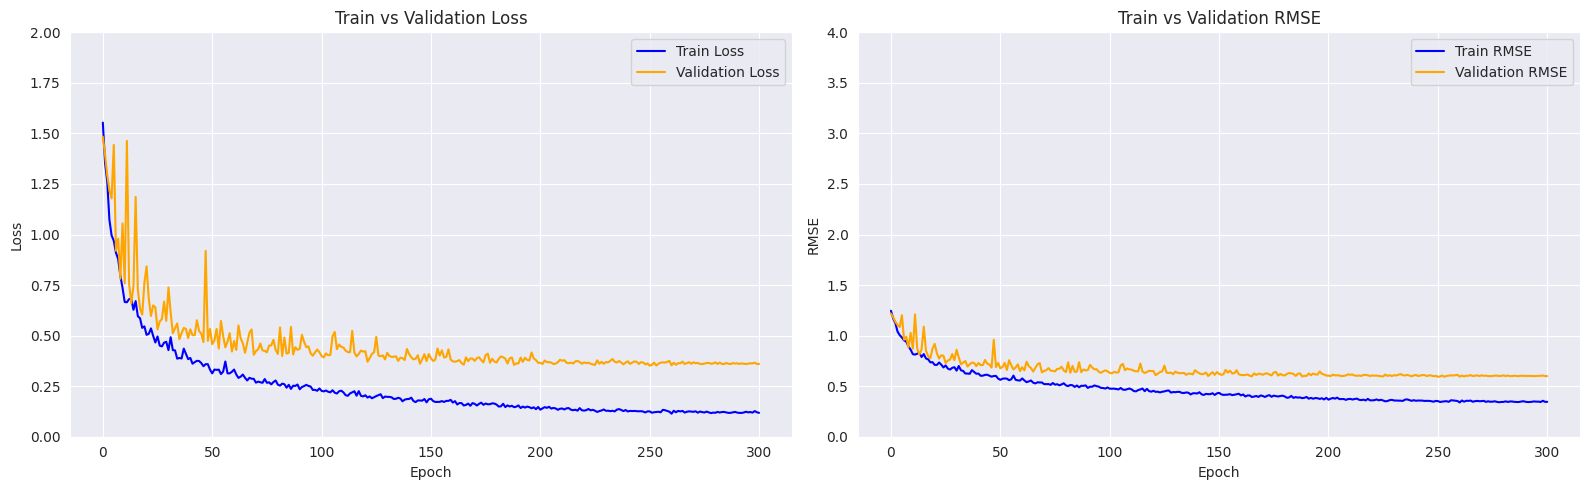

In [16]:
num_runs = 1  

best_val_rmse_comb=float('inf')
best_train_losses=[]
best_train_rmses=[]
best_val_losses=[]
best_val_rmses=[]
best_overall_rmse = float('inf')
best_overall_state = None
best_epoch = None

for i in range(num_runs):
    epoch, rmse, state, train_losses, train_rmses, val_losses, val_rmses= run_training_session(train_loader, val_loader, device, 301, 100, best_combination, False)
    if rmse < best_overall_rmse:
        best_overall_state = state
        best_overall_rmse = rmse
        best_train_losses=train_losses
        best_train_rmses=train_rmses
        best_val_losses=val_losses
        best_val_rmses=val_rmses
        best_epoch = epoch 
        print(f"Mejora encontrada en la iteración {i}: RMSE {val_rmses[best_epoch]} en epoch {best_epoch}")

        
epochs = range(len(best_train_losses))
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(epochs, best_train_losses, label="Train Loss", color="blue")
axes[0].plot(epochs, best_val_losses, label="Validation Loss", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs Validation Loss")
axes[0].set_ylim([0, 2])
axes[0].legend()
axes[0].grid(True)

# RMSE
axes[1].plot(epochs, best_train_rmses, label="Train RMSE", color="blue")
axes[1].plot(epochs, best_val_rmses, label="Validation RMSE", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("RMSE")
axes[1].set_title("Train vs Validation RMSE")
axes[1].set_ylim([0, 4])
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  
plt.show()


RMSE: 0.5928040947076866


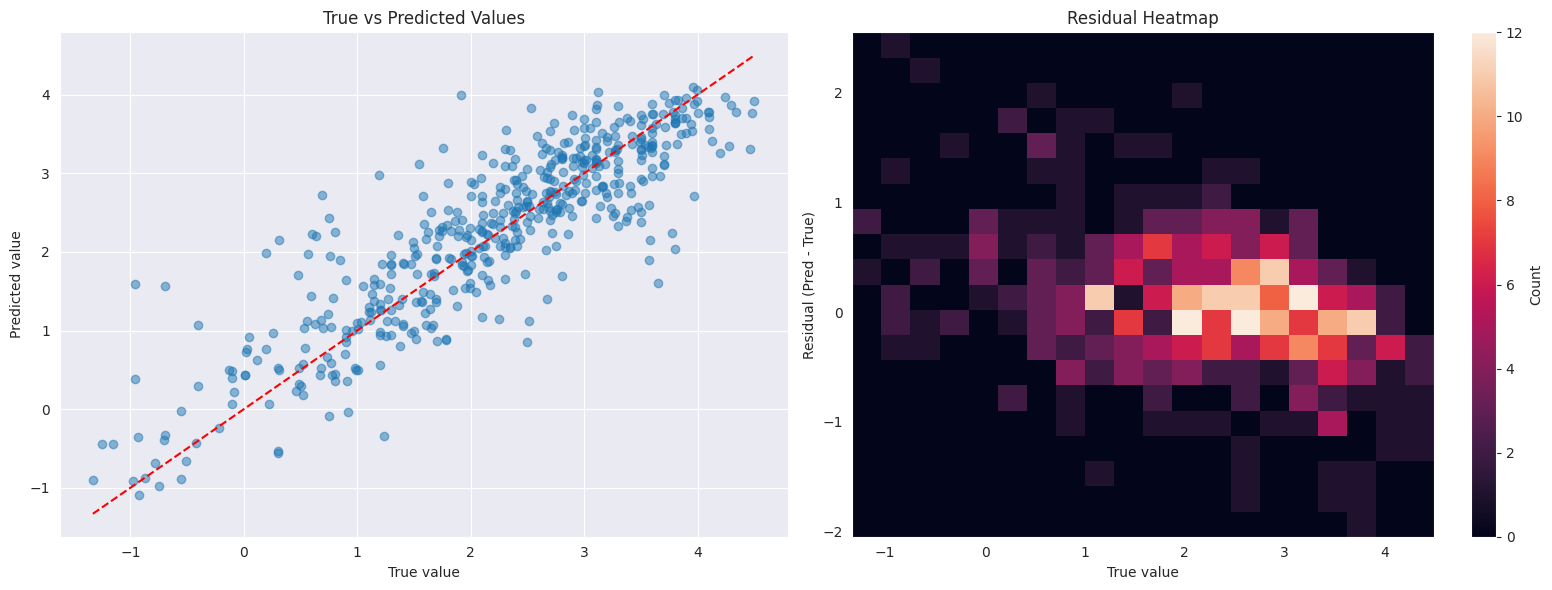

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = GINGraph(dataset.num_features, 1, best_combination[0], best_combination[1], best_combination[2], best_combination[3]).to(device)
model.load_state_dict(best_overall_state)

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")

epochs_data = np.array(y_true).flatten()
pred_data = np.array(y_pred).flatten()

def print_figures(epochs_data, pred_data):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(epochs_data, pred_data, alpha=0.5)
    axes[0].plot([min(epochs_data), max(epochs_data)], [min(epochs_data), max(epochs_data)], color='red', linestyle='--')
    axes[0].set_xlabel("True value")
    axes[0].set_ylabel("Predicted value")
    axes[0].set_title("True vs Predicted Values")
    axes[0].grid(True)

    residuals = pred_data - epochs_data
    hb = axes[1].hist2d(epochs_data, residuals, bins=20)
    plt.colorbar(hb[3], ax=axes[1], label="Count")
    axes[1].set_xlabel("True value")
    axes[1].set_ylabel("Residual (Pred - True)")
    axes[1].set_title("Residual Heatmap")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print_figures(epochs_data, pred_data)

## Test

Entrenamos el modelo optimizado con todos los datos y comparamos con el test set.

RMSE: 0.6292484826469851


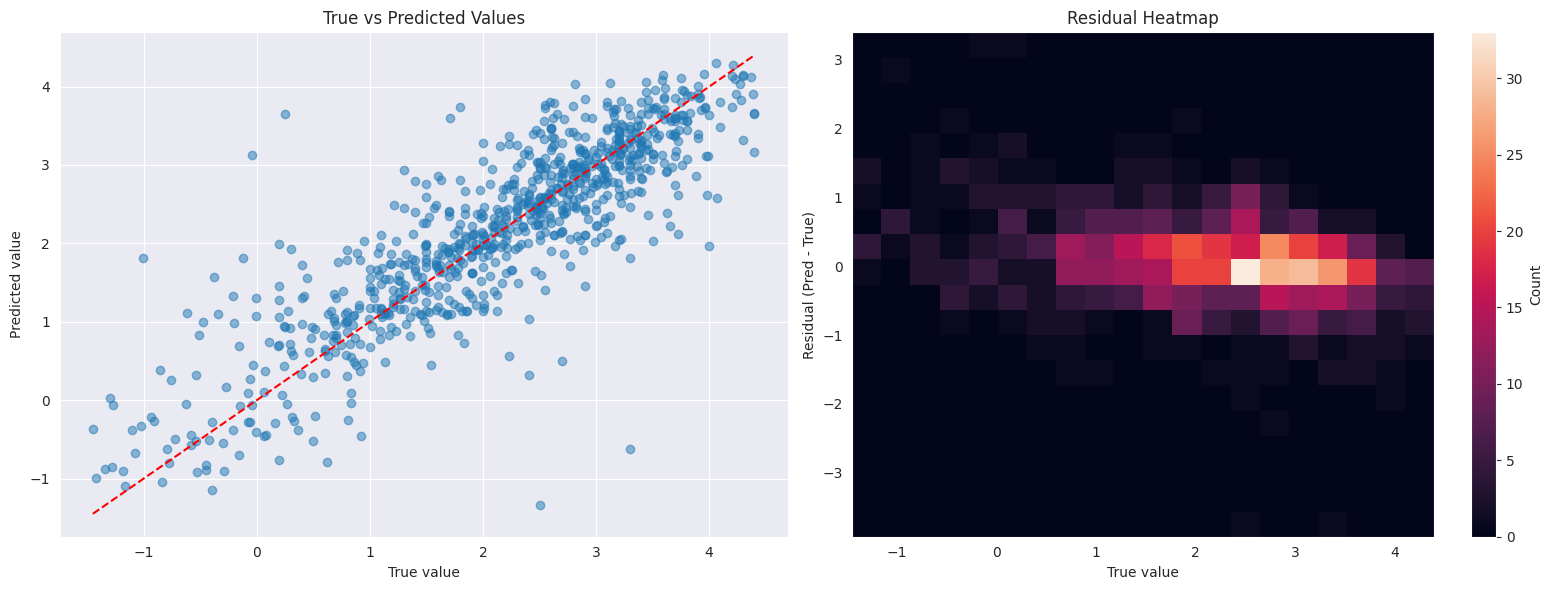

In [ ]:
num_epochs=((best_epoch // 100) % 10)*100+301
patience = None

model_final = GINGraph(dataset.num_features, 1, best_combination[0], best_combination[1], best_combination[2], best_combination[3]).to(device)
optimizer = torch.optim.Adam(model_final.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

for epoch in range(num_epochs):
    train_loss, train_rmse = run_epoch(model_final, train_loader_final, optimizer, device, train=True)

    scheduler.step()

torch.save(model_final.state_dict(), "model_final_all_data.pth")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

model_final.eval()

url = "https://raw.githubusercontent.com/luciacuevascsv/analisis_redes_sociales/main/Practica%20II/test_labels.csv"
test_labels_df = pd.read_csv(url)
test_labels_dict = dict(zip(test_labels_df['id'], test_labels_df['label']))

y_true = []
y_pred = []

with torch.no_grad():
    for idx in dataset.test_idx:
        data = dataset[idx]
        data = data.to(device)
        out = model_final(data)
        y_hat = out.view(-1).cpu().item()

        y_pred.append(y_hat)
        y_true.append(test_labels_dict[data.nid.item()])

print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")

y_true_arr = np.array(y_true).flatten()
y_pred_arr = np.array(y_pred).flatten()

print_figures(y_true_arr, y_pred_arr)